Epoch 1/200, Loss: 10860998.0000
Epoch 2/200, Loss: 9679241.0000
Epoch 3/200, Loss: 7686093.5000
Epoch 4/200, Loss: 7809560.0000
Epoch 5/200, Loss: 8132410.0000
Epoch 6/200, Loss: 5728016.5000
Epoch 7/200, Loss: 5928741.5000
Epoch 8/200, Loss: 6891142.0000
Epoch 9/200, Loss: 8691417.0000
Epoch 10/200, Loss: 6535816.0000
Epoch 11/200, Loss: 9359003.0000
Epoch 12/200, Loss: 7516838.5000
Epoch 13/200, Loss: 9036396.0000
Epoch 14/200, Loss: 6203645.5000
Epoch 15/200, Loss: 7503665.5000
Epoch 16/200, Loss: 7668752.0000
Epoch 17/200, Loss: 6597240.5000
Epoch 18/200, Loss: 4862481.5000
Epoch 19/200, Loss: 5525009.5000
Epoch 20/200, Loss: 8583755.0000
Epoch 21/200, Loss: 6134996.5000
Epoch 22/200, Loss: 5429723.5000
Epoch 23/200, Loss: 7511454.5000
Epoch 24/200, Loss: 10285602.0000
Epoch 25/200, Loss: 7917928.0000
Epoch 26/200, Loss: 5799670.5000
Epoch 27/200, Loss: 8271518.5000
Epoch 28/200, Loss: 7686208.5000
Epoch 29/200, Loss: 9888028.0000
Epoch 30/200, Loss: 6610382.5000
Epoch 31/200, Los

ValueError: x and y must have same first dimension, but have shapes (782,) and (792, 1)

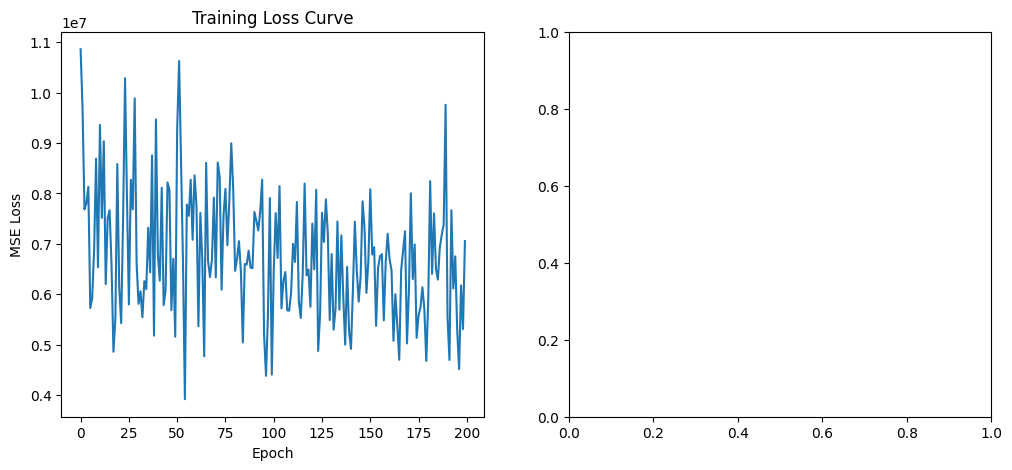

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 可调参数配置
config = {
    "hidden_units": 64,    # 隐藏层神经元数量
    "learning_rate": 0.001,
    "num_epochs": 200,
    "batch_size": 32,
    "sequence_length": 10  # 时间窗口长度（用于处理动态特性）
}

# 生成模拟数据（假设已知大致物理关系）
def generate_data(num_samples=1000):
    t = np.linspace(0, 10, num_samples)  # 时间序列
    rpm = 1000 * (0.5 + 0.5 * np.sin(2 * np.pi * 0.2 * t))  # 转速信号（动态变化）
    
    # 理论角度（积分关系 + 非线性扰动）
    theta_ideal = np.cumsum(rpm) * 0.01  # 假设基本积分关系
    nonlinear = 5 * np.sin(0.5 * t)       # 代表齿轮间隙等非线性因素
    noise = np.random.normal(0, 0.1, num_samples)  # 噪声
    theta_real = theta_ideal + nonlinear + noise
    
    return rpm, theta_real, t

# 创建序列数据集（时间窗口处理）
def create_sequences(rpm, theta, seq_length):
    X, y = [], []
    for i in range(len(rpm) - seq_length):
        X.append(rpm[i:i+seq_length])
        y.append(theta[i+seq_length])
    return np.array(X), np.array(y)

# 数据预处理
rpm, theta, t = generate_data()
X, y = create_sequences(rpm, theta, config["sequence_length"])

# 转换为PyTorch张量
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (samples, seq_len, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# 划分训练集和测试集
train_size = int(0.8 * len(X))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)

# 定义神经网络模型（可调结构）
class DynamicModel(nn.Module):
    def __init__(self, input_size, hidden_units):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_units,
                            batch_first=True)
        self.fc = nn.Linear(hidden_units, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)          # LSTM处理时序
        out = self.fc(out[:, -1, :])   # 取最后时间步输出
        return out

# 初始化模型和优化器
model = DynamicModel(input_size=1, hidden_units=config["hidden_units"])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

# 训练过程
loss_history = []
for epoch in range(config["num_epochs"]):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    loss_history.append(loss.item())
    print(f"Epoch {epoch+1}/{config['num_epochs']}, Loss: {loss.item():.4f}")

# 测试集预测
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")

# 可视化结果
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

plt.subplot(1, 2, 2)
plt.plot(t[config["sequence_length"]:train_size], y_train.numpy(), label="Train True")
plt.plot(t[train_size+config["sequence_length"]:], y_test.numpy(), label="Test True")
plt.plot(t[train_size+config["sequence_length"]:], test_outputs.numpy(), label="Predicted")
plt.title("Prediction vs Ground Truth")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.legend()
plt.show()